# Импорт

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Библиотеки для работы с аудиофайлами
import librosa # Для анализа и обработки аудио
import librosa.display # Для визуализации аудиоданных
import IPython.display as ipd # Для воспроизведения аудиофайлов внутри Jupyter Notebook
# Отключение предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
general_path = '/content'

# Описание датасета

EDA будет выполняться с использованием файла features_3_sec.csv. Этот файл содержит среднее значение и дисперсию для каждого аудиофайла по характеристикам, проанализированным выше.

Итак, итоговая таблица состоит из 1000 строк (10 жанров, 100 аудиофайлов) и 60 характеристик (размерностей).




Жанры:


*   blues
*   classical
*   country
*   disco
*   hip hop
*   jazz
*   metal
*   pop
*   reggae
*   rock

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# Анализ основных компонентов - для визуализации возможных групп жанров



1. Normalization
2. PCA
3. The Scatter Plot

In [ ]:
from sklearn import preprocessing

# Выделение целевой переменной (метки) и признаков, а также удаление первого столбца
data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

## Нормализация

In [ ]:
cols = X.columns
# Создание и применение MinMaxScaler для нормализации данных
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
# Преобразование нормализованных данных обратно в DataFrame
X = pd.DataFrame(np_scaled, columns = cols)

## PCA - метод главных компонет

In [ ]:
from sklearn.decomposition import PCA

# Создание объекта PCA с двумя главными компонентами
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X) # Применение к нормализованным данным
principalDf = pd.DataFrame(data = principalComponents, columns = ['Основной компонент 1', 'Основной компонент 2'])

# Объединение DataFrame с главными компонентами и целевой переменной
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.97003307, 0.0291683 ])

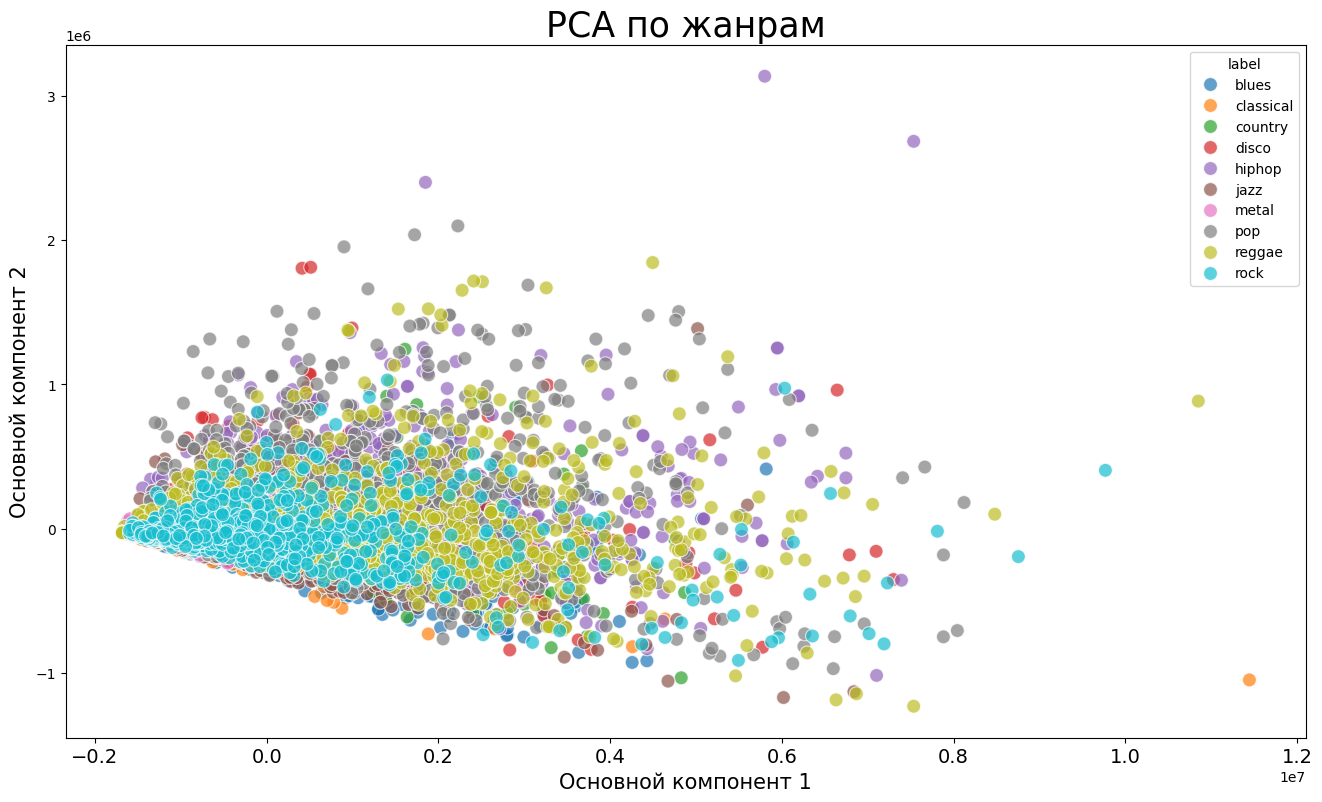

In [ ]:
plt.figure(figsize = (16, 9))
# Создание диаграммы рассеяния
sns.scatterplot(x = "Основной компонент 1", y = "Основной компонент 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA по жанрам', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Основной компонент 1", fontsize = 15)
plt.ylabel("Основной компонент 2", fontsize = 15)
plt.savefig("PCA рассеяние.jpg")

Большинство жанров сильно пересекаются.  Это указывает на то, что многие жанры имеют общие.

Жанры, такие как classical и rock, находятся немного в стороне от основной массы точек, что может означать, что они имеют уникальные особенности по сравнению с другими жанрами.

Большинство жанров, таких как hiphop, pop, jazz, metal, и другие, сильно перекрываются друг с другом, что может указывать на общие аудиохарактеристики.

Есть несколько точек, находящихся далеко от основной массы данных, особенно одна точка, относящаяся к classical жанру на оси X, и несколько точек других жанров на оси Y. Эти точки могут быть выбросами или аномальными записями.

## t-SNE

Позволяет визуализировать данные в двумерном пространстве

In [ ]:
from sklearn.manifold import TSNE

# Создание объекта t-SNE с двумя компонентами и perplexity=10
tsne = TSNE(n_components=2, perplexity=10)
principalComponents = tsne.fit_transform(X) # Применение к нормализованным данным
principalDf = pd.DataFrame(data = principalComponents, columns = ['Основной компонент 1', 'Основной компонент 2'])

# Объединение DataFrame с компонентами t-SNE и целевой переменной
finalDf = pd.concat([principalDf, y], axis = 1)

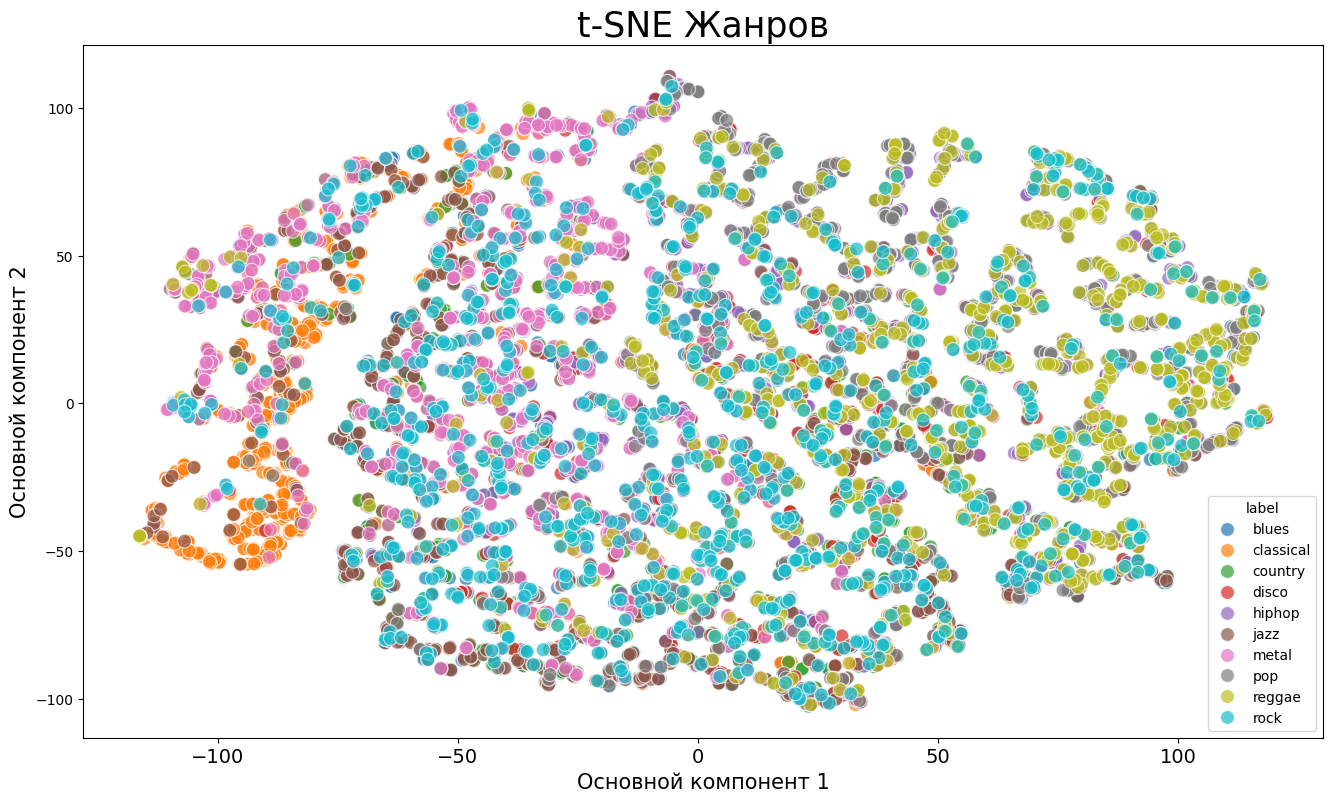

In [ ]:
plt.figure(figsize = (16, 9))
# Создание диаграммы рассеяния
sns.scatterplot(x = "Основной компонент 1", y = "Основной компонент 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('t-SNE Жанров', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Основной компонент 1", fontsize = 15)
plt.ylabel("Основной компонент 2", fontsize = 15)
plt.savefig("t-SNE рассеяние.jpg")



*   Classical (оранжевый) выделяется и образует относительно плотную группу, что указывает на его уникальные характеристики
*   Blues (голубой) и Rock (серый) также имеют тенденцию к образованию кластеров
*   Hiphop (розовый) и Pop (желтый) сильно перемешаны с другими жанрами, что указывает на наличие общих характеристик




В отличие от PCA, t-SNE лучше разделяет данные, показывая более четкие кластеры, несмотря на некоторые перекрытия. Это свидетельствует о том, что t-SNE лучше подходит для выявления сложных структур в данных, чем PCA.

# Machine Learning Classification

Используя файл features_3_sec.csv, мы можем попытаться создать классификатор, который определяет жанр для любого нового входного аудиофайла.



## Библиотеки

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import pickle

## Читаем данные



Попробуем предсказать жанр аудиозаписи, используя методы машинного обучения

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:]
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## Разбиваем датасет

* Разбиваем данные
* Нормализуем данные

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = data['label'] # Таргет
# Преобразование текстовых меток в числовые коды
convertor = LabelEncoder()
y_cat = convertor.fit_transform(y)
# Выделение признаков (X) и целевой переменной (y)
X = data.loc[:, data.columns != 'label']

### Нормализация

Нормализация данных, чтобы все признаки находились в одной шкале

In [ ]:
cols = X.columns
# Создание экземпляра MinMaxScaler для масштабирования данных
min_max_scaler = preprocessing.MinMaxScaler()
# Применение масштабирования к данным
np_scaled = min_max_scaler.fit_transform(X)

# Создание нового DataFrame с отмасштабированными данными
X = pd.DataFrame(np_scaled, columns = cols)

## Разделение данных на обучающие и тестовые

Разделение на 70% и 30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=2024)

## Модель для оченки точности модели




*   Входные данные - модель
*   Обучение модели на обучающем наборе данных
*   Предсказание на тестовых признаках
*   Сравнение предсказанных значений с фактическими



In [ ]:
# Функция для оценки производительности модели
def model_assess(model, title = "Default"):
  # Обучение модели на обучающем наборе данных
    model.fit(X_train, y_train)
    # Предсказание на тестовых признаках
    preds = model.predict(X_test)
    # Вычисление и вывод точности модели
    print('Точность', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

## Были протестированы 10 моделей, чтобы оценить их эффективность



### Xgboost - самая эффективная

In [ ]:
# Наивный байесовский классификатор
nb = GaussianNB()
model_assess(nb, "Наивный Байес")

# Стохастический градиентный спуск
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Стохастический градиентный спуск")

# Метод k ближайших соседей
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "Метод k ближайших соседей")

# Деревья принятия решений
tree = DecisionTreeClassifier()
model_assess(tree, "Деревья принятия решений")

# Случайный лес
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Случайный лес")

# Метод опорных векторов
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Метод опорных векторов")

# Логистическая регрессия
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Логистическая регрессия")

# Нейронные сети
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Нейронные сети")

# Градиентный бустинг
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Градиентный бустинг")

# Градиентный бустинг (Случайный лес)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Градиентный бустинг (Случайный лес)")

Accuracy Наивный Байес : 0.52119 

Accuracy Стохастический градиентный спуск : 0.63764 

Accuracy Метод k ближайших соседей : 0.81481 

Accuracy Деревья принятия решений : 0.63297 

Accuracy Случайный лес : 0.80981 

Accuracy Support Vector Machine : 0.7344 

Accuracy Logistic Regression : 0.67835 

Accuracy Neural Nets : 0.69703 

Accuracy Cross Gradient Booster : 0.90157 

Accuracy Cross Gradient Booster (Random Forest) : 0.74007 



## XGBoost - точность 90%





*   Создание финальной модели
*   Предсказание на тестовом наборе данных
*   Вычисление матрицы ошибок (confusion matrix)
*   Вычисление значимости признаков



### Создание финальной модели

In [ ]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)
# Предсказание на тестовом наборе данных
print('Точность', ':', round(accuracy_score(y_test, preds), 5), '\n')

Точность : 0.90157 



### Матрица ошибок

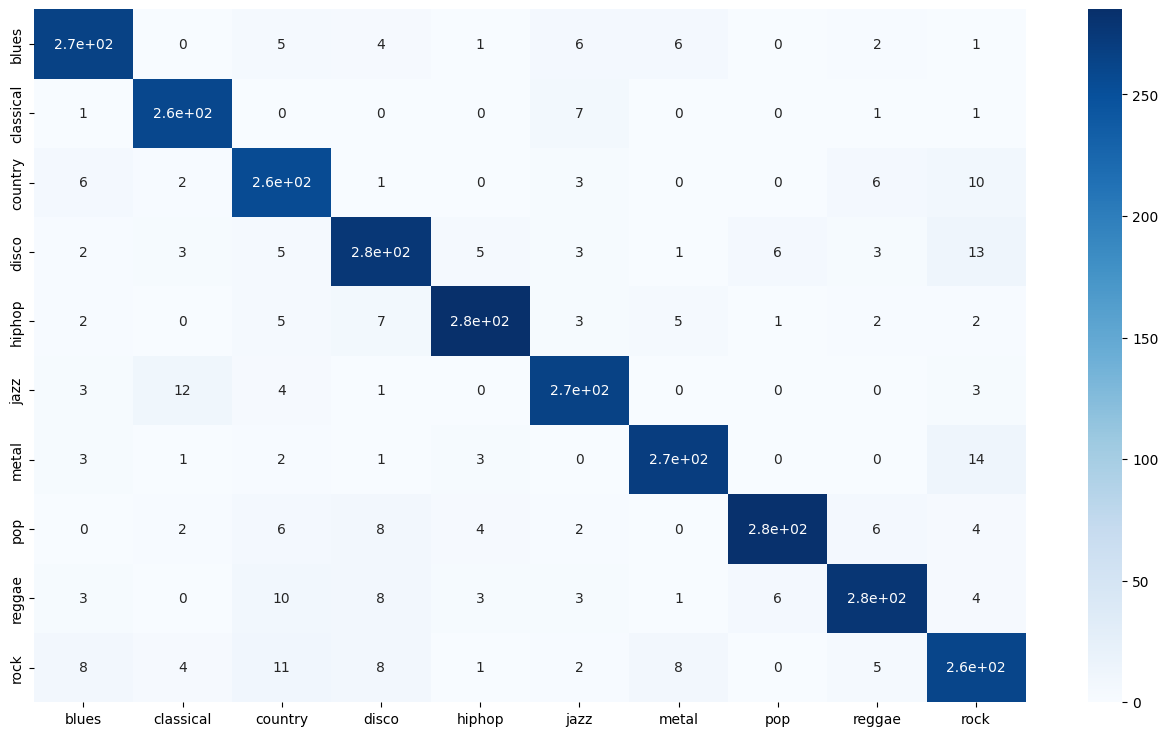

In [ ]:
# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) # Вычисление матрицы ошибок между фактическими метками и предсказанными метками
# Отображение матрицы ошибок в виде тепловой карты
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("Матрица ошибок")

## Сохранение модели

In [ ]:
file_name = "/content/xgb_mgen.pkl"

# Сохранение
pickle.dump(xgb, open(file_name, "wb"))  # Сериализация модели и запись в файл в бинарном режиме

# Загрузка модели из файла
xgb_model_loaded = pickle.load(open(file_name, "rb")) # Десериализация модели из файла в бинарном режиме

## Извлечение метафункции из аудиофайла

Вычисляем статистические моменты и преобразует их в формат, пригодный для модели машинного обучения. Затем он использует модель XGBoost для предсказания стиля музыки на основе этих метафункций

In [ ]:
# Список стилей музыки
style = convertor.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Функция для извлечения метафункций из аудиофайла и преобразования их в нужный формат
def get_meta(p_t):
  # Загрузка аудиофайла
  y, sr = librosa.load(p_t)
  length = 66149 # Задание длины аудиофайла
  # Извлечение статистических моментов для различных признаков аудио (например, среднего и дисперсии)
  chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y = y, sr = sr))
  chroma_stft_var = np.var(librosa.feature.chroma_stft(y = y, sr = sr))
  # Среднеквадратичное значение (RMS)
  rms_mean = np.mean(librosa.feature.rms(y = y))
  rms_var = np.var(librosa.feature.rms(y = y))
  # Спектральный центроид
  spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y = y, sr = sr))
  spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y = y, sr = sr))
  # Спектральная ширина
  spectral_bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y = y, sr = sr))
  spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y = y, sr = sr))
  # Спектральный скат
  rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y = y, sr = sr))
  rolloff_var = np.var(librosa.feature.spectral_rolloff(y = y, sr = sr))
  # Нулевая частота пересечения
  zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y))
  zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(y))
  # Уровень гармонии
  harmony_mean = np.mean(librosa.effects.harmonic(y))
  harmony_var = np.var(librosa.effects.harmonic(y))
  # Уровень ударных звуков
  perceptr_mean = np.mean(librosa.effects.percussive(y))
  perceptr_var = np.var(librosa.effects.percussive(y))
  # Темп музыки
  tempo = librosa.feature.tempo(y = y, sr = sr)

  # Собираем все извлеченные признаки в словарь
  to_cl = {'length': length, 'chroma_stft_mean': chroma_stft_mean, 'chroma_stft_var': chroma_stft_var, 'rms_mean': rms_mean, 'rms_var': rms_var, 'spectral_centroid_mean': spectral_centroid_mean, 'spectral_centroid_var': spectral_centroid_var, 'spectral_bandwidth_mean': spectral_bandwidth_mean, 'spectral_bandwidth_var': spectral_bandwidth_var, 'rolloff_mean': rolloff_mean, 'rolloff_var': rolloff_var, 'zero_crossing_rate_mean': zero_crossing_rate_mean, 'zero_crossing_rate_var': zero_crossing_rate_var, 'harmony_mean': harmony_mean, 'harmony_var': harmony_var, 'perceptr_mean': perceptr_mean, 'perceptr_var': perceptr_var, 'tempo': tempo[0]}

  # Извлечение мел-частотных кепстральных коэффициентов (MFCC)
  mfcc = librosa.feature.mfcc(y = y, sr = sr)

  i = 1
  # Добавление средних и дисперсий MFCC в словарь
  for e in mfcc:
      s_m = 'mfcc' + str(i) + '_mean'
      s_v = 'mfcc' + str(i) + '_var'

      to_cl[s_m] = np.mean(e)
      to_cl[s_v] = np.var(e)
      i+=1
  # Преобразование словаря признаков в массив и масштабирование значений
  to_mod = min_max_scaler.transform(np.array(list(to_cl.values())).reshape(1, 58))
  return to_mod
# Функция для предсказания стиля музыки по аудиофайлу
def get_style(p_t):
  # Предсказание метки стиля с помощью загруженной модели XGBoost
  return style[xgb_model_loaded.predict(get_meta(p_t))][0]

In [ ]:
# Принимает путь к аудиофайлу и возвращает предсказанный стиль музыки на основе извлеченных признаков из этого аудиофайла
p_t = '/content/blues.00000.wav'
get_style(p_t)

'blues'